In [1]:
# Import all stuff we need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pylab

from brian import Network, Equations, NeuronGroup, Connection,\
    SpikeMonitor, raster_plot, StateMonitor, clear, reinit
from brian.stdunits import ms, mV

%matplotlib inline
pylab.rcParams['figure.figsize'] = 12, 8  # changes figure size (width, height) for larger images

/Users/Jan/.virtualenvs/research/lib/python2.7/site-packages/brian/utils/sparse_patch/__init__.py:39: UserWarning: Couldn't find matching sparse matrix patch for scipy version 0.15.1, but in most cases this shouldn't be a problem.
  warnings.warn("Couldn't find matching sparse matrix patch for scipy version %s, but in most cases this shouldn't be a problem." % scipy.__version__)


In [2]:
clear(True, True) 
reinit()# To reinit BRIAN clocks and remove all old BRIAN objects from namespace,
# it's usually a good idea to put this at the beginning of a script

In [15]:
# The equations defining our neuron model
eqs_string = ''' 
            dV/dt = (mu - V)/tau + x: volt
            dx/dt = -1.0/tau_2*(x - y/tau_1) : volt/second
            dy/dt = -y/tau_1 : volt
            mu : volt
            tau: second
            tau_2: second
            tau_1: second
            '''

In [26]:
# Our model parameters
tau_e = 15*ms # membrane time constant (for excitatory synapses)
tau_i = 10*ms # membrane time constant (for inhibitory synapses)
tau_syn_2_e = 3*ms # exc synaptic time constant tau2 in paper
tau_syn_2_i = 2*ms # inh synaptic time constant tau2 in paper
tau_syn_1 = 1*ms # exc/inh synaptic time constant tau1 in paper
V_th = -50*mV # firing threshold
V_reset = -65*mV # reset potential
refr_period = 5*ms # absolute refractory period
wee = 0.024 * 15*mV
wei = -0.045 * 15*mV
wii = -0.057 * 15*mV
wie = 0.014 * 15*mV

# Number of neurons
N_e = 4000 # number of exc neurons
N_i = 1000 # number of inh neurons

# Our parameters for the bias mu
mu_e = np.random.uniform(1.1, 1.2, N_e) * (V_th-V_reset) # bias for excitatory neurons
mu_i = np.random.uniform(1.0, 1.05, N_i) * (V_th-V_reset) # bias for excitatory neurons

# Connection probability
conn_prob_ee = 0.2
conn_prob_ii = 0.5
conn_prob_ei = 0.5
conn_prob_ie = 0.5

# Duration of our simulation
duration = 500*ms

In [17]:
# Let's create an equation object from our string and parameters
model_eqs = Equations(eqs_string)

In [18]:
# Let's create 5000 neurons
all_neurons = NeuronGroup(N=N_e+N_i,
                          model=model_eqs,
                          threshold=V_th,
                          reset=V_reset,
                          refractory=refr_period,
                          freeze = True,
                          method='Euler',
                          compile=True)

brian.equations   : WARNING  Equation variable x also exists in the namespace
brian.equations   : WARNING  Equation variable y also exists in the namespace
brian.equations   : WARNING  Equation variable x also exists in the namespace
brian.equations   : WARNING  Equation variable y also exists in the namespace


In [19]:
# Divide the neurons into excitatory and inhibitory ones
neurons_e = all_neurons[0:N_e]
neurons_i = all_neurons[N_e:N_e+N_i]

In [20]:
# set the bias
neurons_e.mu = mu_e
neurons_i.mu = mu_i
neurons_e.tau = tau_e
neurons_i.tau = tau_i
neurons_e.tau_2 = tau_syn_2_e
neurons_i.tau_2 = tau_syn_2_i
all_neurons.tau_1 = tau_syn_1

In [21]:
Cee = Connection(neurons_e, neurons_e, 'y', sparseness=conn_prob_ee, weight=wee)
Cei = Connection(neurons_e, neurons_i, 'y', sparseness=conn_prob_ei, weight=wei)
Cie = Connection(neurons_i, neurons_e, 'y', sparseness=conn_prob_ie, weight=wie)
Cii = Connection(neurons_i, neurons_i, 'y', sparseness=conn_prob_ii, weight=wii)

In [22]:
spike_mon_e = SpikeMonitor(neurons_e)
spike_mon_i = SpikeMonitor(neurons_i)
state_mon_v_e = StateMonitor(neurons_e, 'V', record=[0,1,2])
state_mon_v_i = StateMonitor(neurons_i, 'V', record=[0,1])

In [30]:
all_neurons.V = V_reset + (V_th - V_reset) * np.random.rand(len(all_neurons))

In [28]:
network = Network(all_neurons, Cee, Cei, Cie, Cii, spike_mon_e, state_mon_v_e)
network.add(spike_mon_i, state_mon_v_i)

network.run(500*ms, report='text')

100% complete, 8s elapsed, approximately 0s remaining.


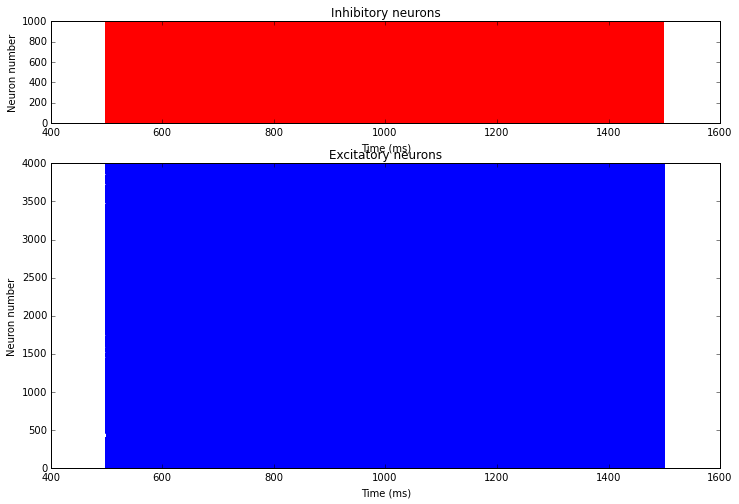

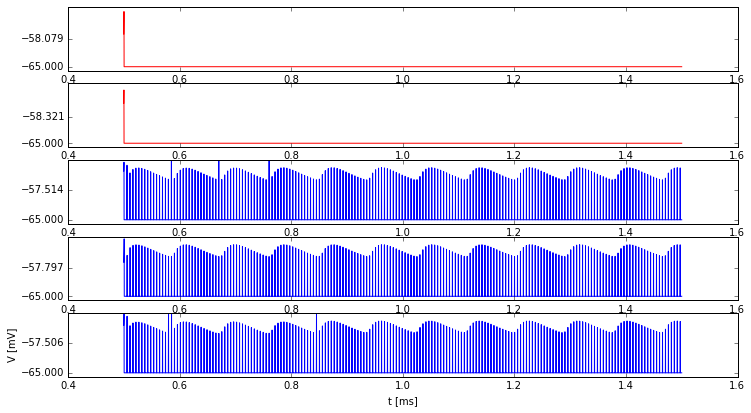

In [29]:
# Plot spike raster plots, blue exc neurons, red inh neurons
plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
plt.subplot(gs[0])
raster_plot(spike_mon_i, color='r')
plt.title('Inhibitory neurons')
plt.subplot(gs[1])
raster_plot(spike_mon_e)
plt.title('Excitatory neurons')

# Plot the evolution of the membrane potentials
plt.figure()
for irun in range(1,6):
    plt.subplot(6,1,irun)
    if irun < 3:
        mon = state_mon_v_i
        idx = irun-1
        color='r'
    else:
        mon = state_mon_v_e
        idx = irun-3
        color='b'

    y =  mon.values[idx,:]*1000.0 # Converting to mV
    x = mon.times
    plt.plot(x, y, color)
    plt.yticks([min(y), (max(y)-min(y))/2.0+min(y)])

    if irun == 5:
        plt.xlabel('t [ms]')
        plt.ylabel('V [mV]')

# Show the plots
plt.show()